<a href="https://colab.research.google.com/github/IanVlasov/GB_kaggle/blob/lesson_1/Vlasov_Yan_HW01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from typing import List, Optional
from tqdm import tqdm

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
DATA_PATH = '/content/drive/My Drive/GB_kaggle/lesson_1/data'
TRAIN_PATH = os.path.join(DATA_PATH, 'train.csv')
TEST_PATH = os.path.join(DATA_PATH, 'test.csv')
TARGET_COLUMN = 'target'

# EDA

## Базовый анализ

In [4]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)

print("train.shape = {} rows, {} cols".format(*train.shape))
print("test.shape = {} rows, {} cols".format(*test.shape))

train.shape = 200000 rows, 202 cols
test.shape = 200000 rows, 201 cols


#### Предварительный обзор

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [6]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,...,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,...,29.4846,5.8683,3.8208,15.8348,-5.0121,15.1345,3.2003,9.3192,3.8821,5.7999,5.5378,5.0988,22.0330,5.5134,30.2645,10.4968,-7.2352,16.5721,-7.3477,11.0752,-5.5937,9.4878,-14.9100,9.4245,22.5441,-4.8622,7.6543,-15.9319,13.3175,-0.3566,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,5.9525,-0.3249,-11.2648,14.1929,7.3124,7.5244,14.6472,7.6782,-1.7395,4.7011,20.4775,17.7559,18.1377,1.2145,3.5137,5.6777,13.2177,-7.9940,-2.9029,5.8463,6.1439,-11.1025,12.4858,-2.2871,19.0422,11.0449,4.1087,4.6974,6.9346,...,13.2070,5.8442,4.7086,5.7141,-1.0410,20.5092,3.2790,-5.5952,7.3176,5.7690,-7.0927,-3.9116,7.2569,-5.8234,25.6820,10.9202,-0.3104,8.8438,-9.7009,2.4013,-4.2935,9.3908,-13.2648,3.1545,23.0866,-5.3000,5.3745,-6.2660,10.1934,-0.8417,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,8.2450,2.3061,2.8102,13.8463,11.9704,6.4569,14.8372,10.7430,-0.4299,15.9426,13.7257,20.3010,12.5579,6.8202,2.7229,12.1354,13.7367,0.8135,-0.9059,5.9070,2.8407,-15.2398,10.4407,-2.5731,6.1796,10.6093,-5.9158,8.1723,2.8521,...,31.8833,5.9684,7.2084,3.8899,-11.0882,17.2502,2.5881,-2.7018,0.5641,5.3430,-7.1541,-6.1920,18.2366,11.7134,14.7483,8.1013,11.8771,13.9552,-10.4701,5.6961,-3.7546,8.4117,1.8986,7.2601,-0.4639,-0.0498,7.9336,-12.8279,12.4124,1.8489,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,7.6784,-9.4458,-12.1419,13.8481,7.8895,7.7894,15.0553,8.4871,-3.0680,6.5263,11.3152,21.4246,18.9608,10.1102,2.7142,14.2080,13.5433,3.1736,-3.3423,5.9015,7.9352,-3.1582,9.4668,-0.0083,19.3239,12.4057,0.6329,2.7922,5.8184,...,33.5107,5.6953,5.4663,18.2201,6.5769,21.2607,3.2304,-1.7759,3.1283,5.5518,1.4493,-2.6627,19.8056,2.3705,18.4685,16.3309,-3.3456,13.5261,1.7189,5.1743,-7.6938,9.7685,4.8910,12.2198,11.8503,-7.8931,6.4209,5.9270,16.0201,-0.2829,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [7]:
train.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,...,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,7.567236,0.394340,-3.245596,14.023978,8.530232,7.537606,14.573126,9.333264,-5.696731,15.244013,12.438567,13.290894,17.257883,4.305430,3.019540,10.584400,13.667496,-4.055133,-1.137908,5.532980,5.053874,-7.687740,10.393046,-0.512886,14.774147,11.434250,3.842499,2.187230,5.868899,10.642131,...,24.259300,5.633293,5.362896,11.002170,-2.871906,19.315753,2.963335,-4.151155,4.937124,5.636008,-0.004962,-0.831777,19.817094,-0.677967,20.210677,11.640613,-2.799585,11.882933,-1.014064,2.591444,-2.741666,10.085518,0.719109,8.769088,12.756676,-3.983261,8.970274,-10.335043,15.377174,0.746072,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,1.235070,5.500793,5.970253,0.190059,4.639536,2.247908,0.411711,2.557421,6.712612,7.851370,7.996694,5.876254,8.196564,2.847958,0.526893,3.777245,0.285535,5.922210,1.523714,0.783367,2.615942,7.965198,2.159891,2.587830,4.322325,0.541614,5.179559,3.119978,2.249730,4.278903,...,10.880263,0.217938,1.419612,5.262056,5.457784,5.024182,0.369684,7.798020,3.105986,0.369437,4.424621,5.378008,8.674171,5.966674,7.136427,2.892167,7.513939,2.628895,8.579810,2.798956,5.261243,1.371862,8.963434,4.474924,9.318280,4.725167,3.189759,11.574708,3.944604,0.976348,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,3.970500,-20.731300,-26.095000,13.434600,-6.011100,1.013300,13.076900,0.635100,-33.380200,-10.664200,-12.402500,-5.432200,-10.089000,-5.322500,1.209800,-0.678400,12.720000,-24.243100,-6.166800,2.089600,-4.787200,-34.798400,2.140600,-8.986100,1.508500,9.816900,-16.513600,-8.095100,-1.183400,-6.337100,...,-7.452200,4.852600,0.623100,-6.531700,-19.997700,3.816700,1.851200,-35.969500,-5.250200,4.258800,-14.506000,-22.479300,-11.453300,-22.748700,-2.995300,3.241500,-29.116500,4.952100,-29.273400,-7.856100,-22.037400,5.416500,-26.001100,-4.808200,-18.489700,-22.583300,-3.022300,-47.753600,4.412300,-2.554300,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.26

#### Анализ пропусков

In [8]:
print(f'Всего в тренировочном датасете пропущенных значений: {train.isna().values.sum()}')
print(f'Всего в тестовом датасете пропущенных значений: {test.isna().values.sum()}')

Всего в тренировочном датасете пропущенных значений: 0
Всего в тестовом датасете пропущенных значений: 0


### Типы признаков

#### Дискретные признаки

In [9]:
numerical_features = train.select_dtypes(include=[np.float])
print(f"count of numeric_features {numerical_features.shape[1]}")

count of numeric_features 200


In [10]:
discrete_feature = [
    feature for feature in numerical_features
    if len(train[feature].unique())<500
]

print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 1


In [11]:
train[discrete_feature].describe()

,var_68
count,200000.000000
mean,5.018893
std,0.007186
min,4.993800
25%,5.014000
50%,5.019100
75%,5.024100
max,5.046900


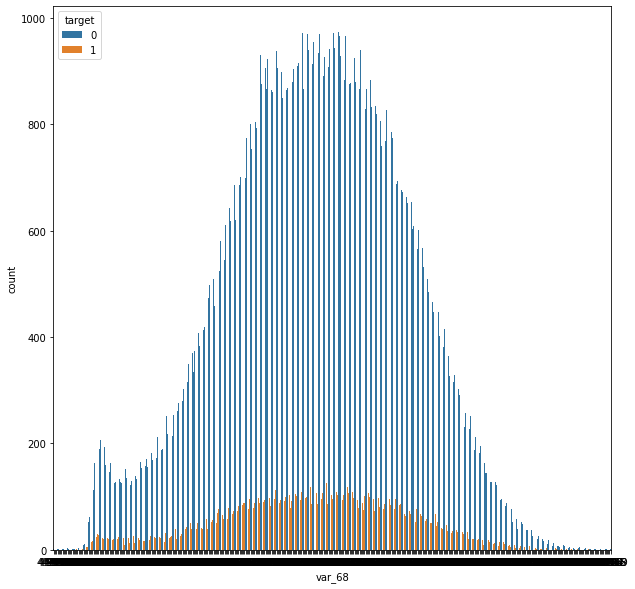

In [12]:
fig = plt.figure(figsize=(10, 10))
sns.countplot(x=discrete_feature[0], hue=train[TARGET_COLUMN], data=train)

#### Непрерывные признаки

In [13]:
continuous_feature = numerical_features

### Вывод

Как видно из предварительного обзора, признаки анонимизированы, не имеют пропусков, почти все имею тип float, за исключением целевой переменной и признака **'ID_code'**, который не несет смысловой нагрузки и является просто представлением ID записи. Был найден один признак с количеством уникальных значений менее 500 (0.25% от всего датасета, **var_68**). Он имеет достатоно узкий диапазон значений (от 4.99 до 5.05). Тем не менее работать с ним будем как с непрерывным, так как 500 все-таки довольно большое число для выделения отдельных категорий. Так как признаки анонимизированы нельзя с уверенностью сказать, что этот признак действительно категориальный

## Анализ целевой переменной

#### Распределение целевой переменной

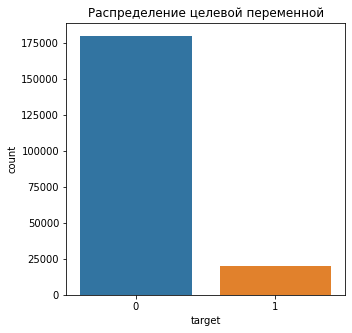

In [14]:
target = train[TARGET_COLUMN]
fig = plt.figure(figsize=(5, 5))
sns.countplot(x=TARGET_COLUMN, data=train)
plt.title('Распределение целевой переменной')
plt.show()

In [15]:
train[TARGET_COLUMN].value_counts(normalize=True)

0    0.89951
1    0.10049
Name: target, dtype: float64

### ВЫВОД

Видно, что данные несбалансированы относительно целевой переменной. 90% наблюдений имеет 0  в target. Вероятно, мы имеем дело с задачей определения отказов. 

## 1.3 Построить распределение признаков в зависимости от значения целевой переменной и распределение признаков для обучающей и тестовой выборки, сделать выводы

#### Распределение признаков в зависимости от значения целевой переменной

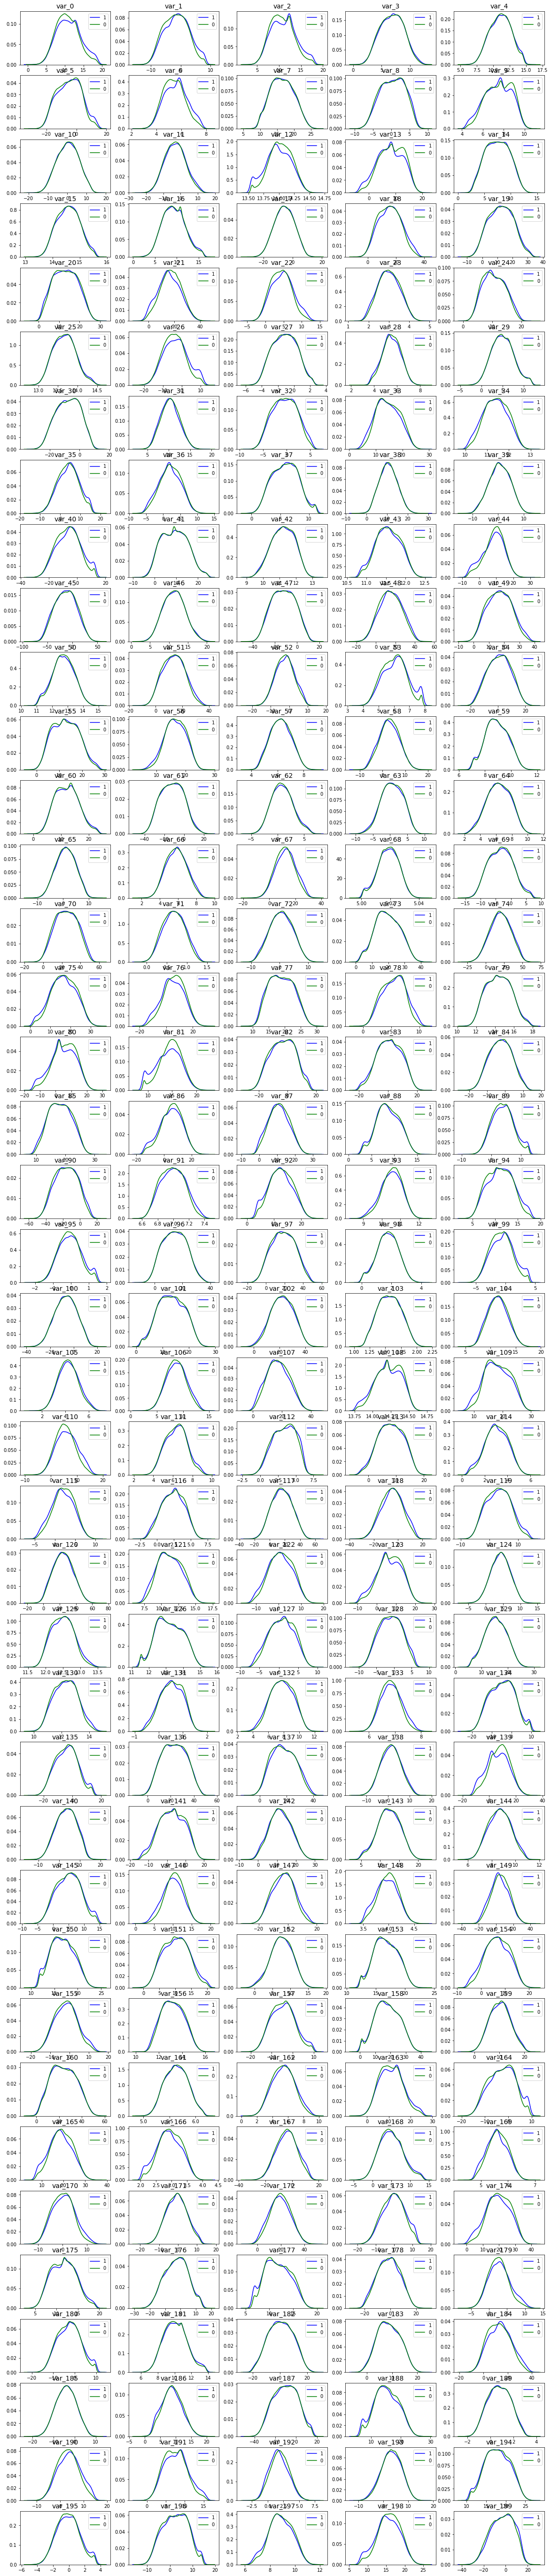

In [16]:
fig, axes = plt.subplots(40, 5, figsize=(20, 100))
axes = axes.flatten()

for num, feature in enumerate(continuous_feature):
    try:
        positive_data = train.loc[train[TARGET_COLUMN] == 1, feature].copy()
        negative_data = train.loc[train[TARGET_COLUMN] == 0, feature].copy()
        sns.kdeplot(positive_data, ax=axes[num], color="blue", label="1")
        sns.kdeplot(negative_data, ax=axes[num], color="green", label="0")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num], color="blue", label="train")
    axes[num].set_title(feature, fontsize=14)

#### Распределение признаков для обучающей и тестовой выборки



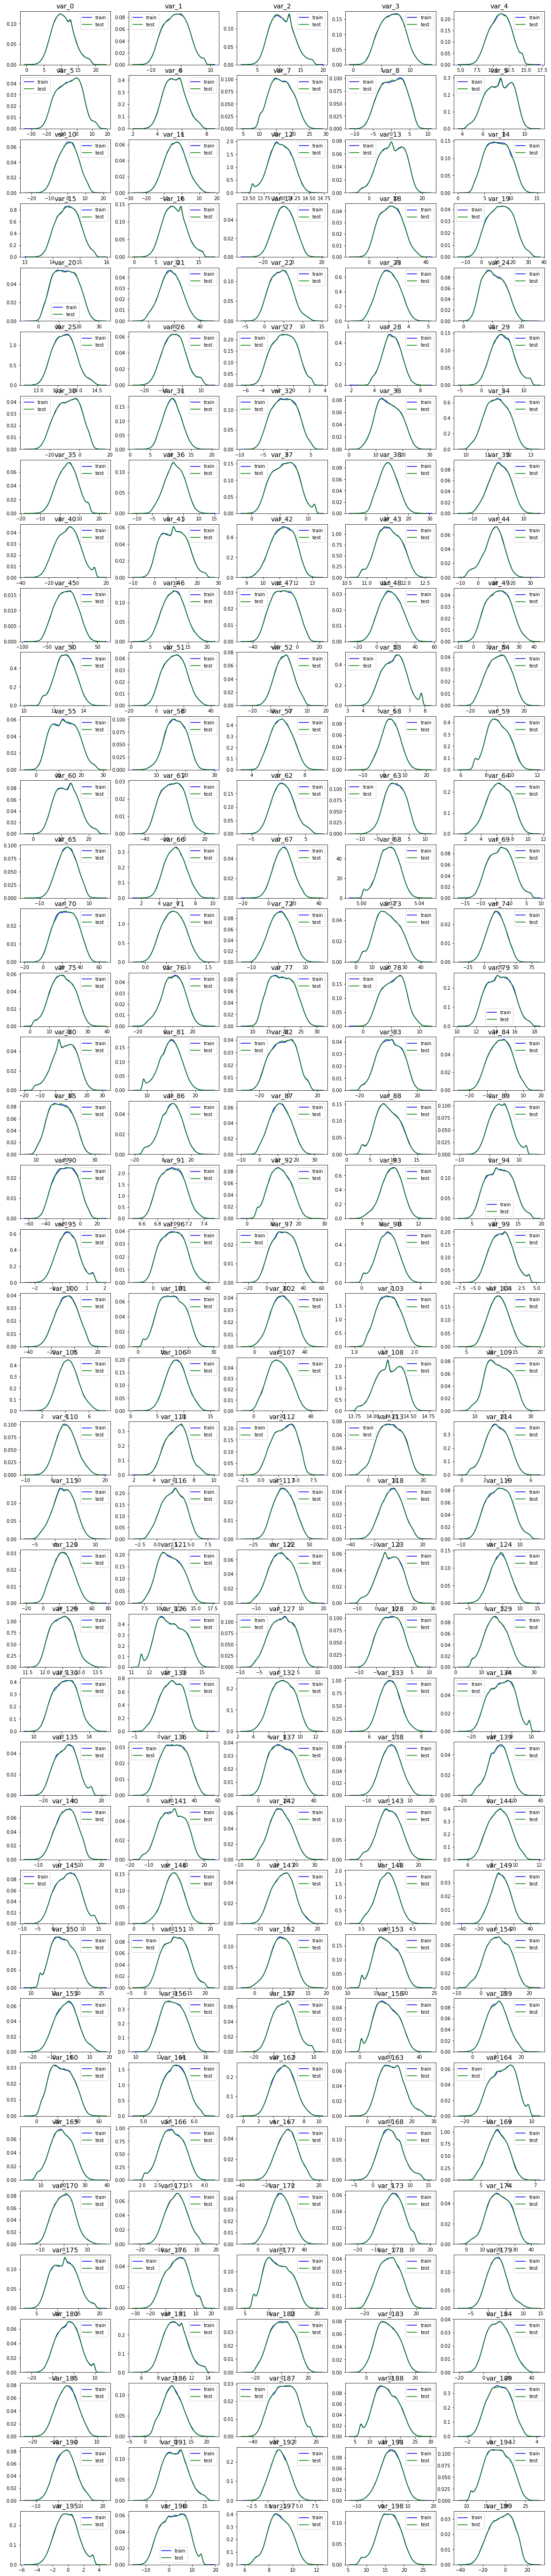

In [17]:
fig, axes = plt.subplots(40, 5, figsize=(20, 100))
axes = axes.flatten()

for num, feature in enumerate(continuous_feature):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num], color="blue", label="train")
    axes[num].set_title(feature, fontsize=14)

#### PSI

In [18]:
class PSI(BaseEstimator, TransformerMixin):
    """
    Вычисление PSI и отбор признаков на их основе.

    Parameters
    ----------
    threshold: float
        Порог для отбора переменных по PSI.
        Если PSI для переменной выше порога - переменная макрируется
        0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

    categorical_features: List[str], optional, default = None
        Список категориальных признаков для анализа.
        Опциональный параметр, по умолчанию, не используется, т.е.
        категориальные признаки отсутствуют.

    n_bins: int, optional, default = 20
        Количество бинов, на которые разбивается выборка.

    min_value: float, optional, default = 0.005
        Значение которое используется, если рассчитанный psi = 0.

    bin_type: string, optional, default = "quanitles"
        Способ разбиения на бины: "quantiles" or "bins".
        При выборе "quantiles" - выборка будет разбита на n_bins
        квантилей, при выборке "bins" - выборка будет разбита на
        n_bins бакетов с равным шагом между бакетами.
        Иные значения приводят к возникновению ValueError.

    Attributes
    ----------
    scores_: Dict[str, float]
        Словарь со значениями PSI,
        ключ словаря - название признака, значение - PSI-score.

    """
    def __init__(self,
                 threshold: float,
                 categorical_features: Optional[List[str]] = None,
                 bin_type: str = "quantiles",
                 min_value: float = 0.005,
                 n_bins: int = 20):

        self.threshold = threshold
        self.categorical_features = categorical_features
        self.min_value = min_value
        self.n_bins = n_bins
        if bin_type in ["quantiles", "bins"]:
            self.bin_type = bin_type
        else:
            raise ValueError(
                "Incorrect bin_type value. Expected 'quantiles' or 'bins', "
                f"but {bin_type} is transferred."
            )
        self.scores = {}

    def calculate_bins(self, data: pd.Series) -> np.array:
        """
        Вычисление границ бинов для разбиения выборки.

        Parameters
        ----------
        data: pandas.Series, shape = [n_samples, ]
            наблюдения из train-выборки.

        Returns
        -------
        bins: numpy.array, shape = [self.n_bins + 1]
            Список с границами бинов.

        """
        if self.bin_type == "quantiles":
            bins = np.linspace(0, 100, self.n_bins + 1)
            bins = [np.nanpercentile(data, x) for x in bins]

        else:
            bins = np.linspace(data.min(), data.max(), self.n_bins + 1)

        return np.unique(bins)

    def calculate_psi_in_bin(self, expected_score, actual_score) -> float:
        """
        Вычисление значения psi для одного бакета.

        Осуществляется проверка на равенство нулю expected_score и
        actual_score: если один из аргументов равен нулю, то его
        значение заменяется на self.min_value.

        Parameters
        ----------
        expected_score: float
            Ожидаемое значение.

        actual_score: float
            Наблюдаемое значение.

        Returns
        -------
        value: float
            Значение psi в бине.

        """
        if expected_score == 0:
            expected_score = self.min_value
        if actual_score == 0:
            actual_score = self.min_value

        value = (expected_score - actual_score)
        value = value * np.log(expected_score / actual_score)

        return value

    def calculate_psi(self, expected: pd.Series, actual: pd.Series, bins) -> float:
        """
        Расчет PSI для одной переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        bins: pandas.Series, shape = [self.n_bins, ]
            Бины для расчета PSI.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        expected_score = np.histogram(expected.fillna(-9999), bins)[0]
        expected_score = expected_score / expected.shape[0]

        actual_score = np.histogram(actual.fillna(-9999), bins)[0]
        actual_score = actual_score / actual.shape[0]

        psi_score = np.sum(
            self.calculate_psi_in_bin(exp_score, act_score)
            for exp_score, act_score in zip(expected_score, actual_score)
        )

        return psi_score

    def calculate_numeric_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для числовой переменной.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = self.calculate_bins(expected)
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def calculate_categorical_psi(self, expected: pd.Series, actual: pd.Series) -> float:
        """
        Вычисление PSI для категориальной переменной.
        PSI рассчитывается для каждого уникального значения категории.

        Parameters
        ----------
        expected: pandas.Series, shape = [n_samples_e, ]
            Наблюдения из train-выборки.

        actual: pandas.Series, shape = [n_samples_o, ]
            Наблюдения из test-выборки.

        Returns
        -------
        psi_score: float
            PSI-значение для данной пары выборок.

        """
        bins = np.unique(expected).tolist()
        psi_score = self.calculate_psi(expected, actual, bins)
        return psi_score

    def fit(self, X, y=None):
        """
        Вычисление PSI-значения для всех признаков.

        Parameters
        ----------
        X: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        y: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        self
        """
        missed_columns = list(set(X.columns) - set(y.columns))

        if missed_columns:
            raise MissedColumnError(
                f"Missed {list(missed_columns)} columns in data.")

        if self.categorical_features:
            numeric_features = list(
                set(X.columns) - set(self.categorical_features)
            )
            for feature in self.categorical_features:
                self.scores[feature] = self.calculate_categorical_psi(
                    X[feature], y[feature]
                )
        else:
            numeric_features = X.columns

        for feature in tqdm(numeric_features):
            self.scores[feature] = self.calculate_numeric_psi(
                X[feature], y[feature]
            )
        return self

    def transform(self, X, y=None) -> pd.DataFrame:
        """
        Отбор переменных по self.threshold.
        Если PSI-score для переменной выше порога, то переменная
        помечается 0 (не использовать для дальнейшего анализа), если ниже
        порога - маркируется 1 (использовать для дальнейшего анализа).

        Parameters
        ----------
        data: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для обучения.

        target: pandas.DataFrame, shape = [n_samples, n_features]
            Матрица признаков для тестирования.

        Returns
        -------
        scores: pandas.DataFrame, shape = [n_features, 3]
            Датафрейм с PSI-анализом переменных.

        """
        check_is_fitted(self, "scores")
        scores = pd.Series(self.scores)
        scores = pd.DataFrame({"Variable": scores.index, "PSI": scores.values})
        scores["Selected"] = np.where(scores.PSI < self.threshold, 1, 0)
        scores = scores.sort_values(by="PSI")

        mask = scores["Selected"] == 1
        self.used_features = scores.loc[mask, "Variable"].tolist()

        return scores.reset_index(drop=True)

In [24]:
features_to_score = continuous_feature.columns.tolist()
psi = PSI(threshold=0.01)

In [25]:
psi.fit_transform(
    X=train[features_to_score],
    y=test[features_to_score]
)

100%|██████████| 200/200 [00:18<00:00, 10.92it/s]


,Variable,PSI,Selected
0,var_154,0.000085,1
1,var_156,0.000132,1
2,var_5,0.000138,1
3,var_148,0.000150,1
4,var_35,0.000151,1
...,...,...,...
195,var_124,0.000615,1
196,var_79,0.000628,1
197,var_162,0.000639,1
198,var_29,0.000667,1


#### Adversarial Validation

In [26]:
X_adv = pd.concat([
    train[features_to_score], test[features_to_score]
])
y_adv = np.hstack(
    (np.ones(train.shape[0]), np.zeros(test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [27]:
%%time
parameters = {"max_depth": 4, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5099
CPU times: user 17min 47s, sys: 1.75 s, total: 17min 49s
Wall time: 9min 7s


### ВЫВОД

Визуально, а также согласно последующему анализу нет признаков сильно различающихся по распределению в тренировочной и тестовой выборках.<br>
Также нет явно разделяющих целевую переменную признаков, но довольно много признаков имеют слегка различное распределение в зависимости от целевого значения

## Анализ связей между признаками

### Корреляционный анализ

In [34]:
correlation = train.corr()
corr_with_target = correlation[TARGET_COLUMN].sort_values(ascending = False)
corr_with_target[abs(corr_with_target) > 0.2]

target    1.0
Name: target, dtype: float64

Text(0, 0.5, 'Density')

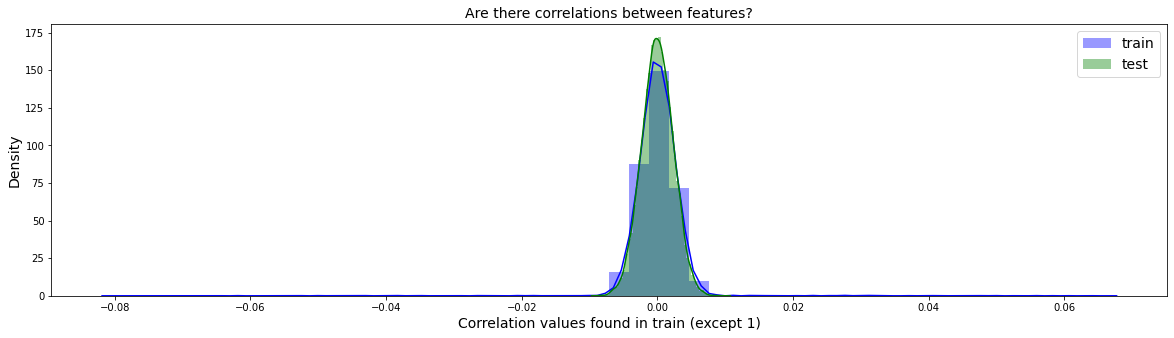

In [37]:
train_correlations = train.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()

test_correlations = test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

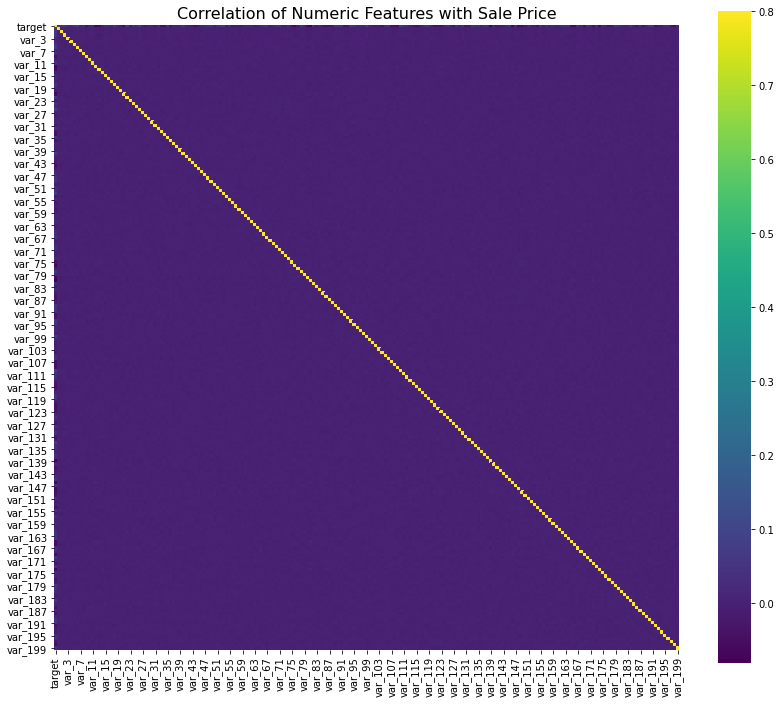

In [38]:
fig, axes = plt.subplots(figsize = (14,12))
plt.title("Correlation of Numeric Features with Sale Price", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

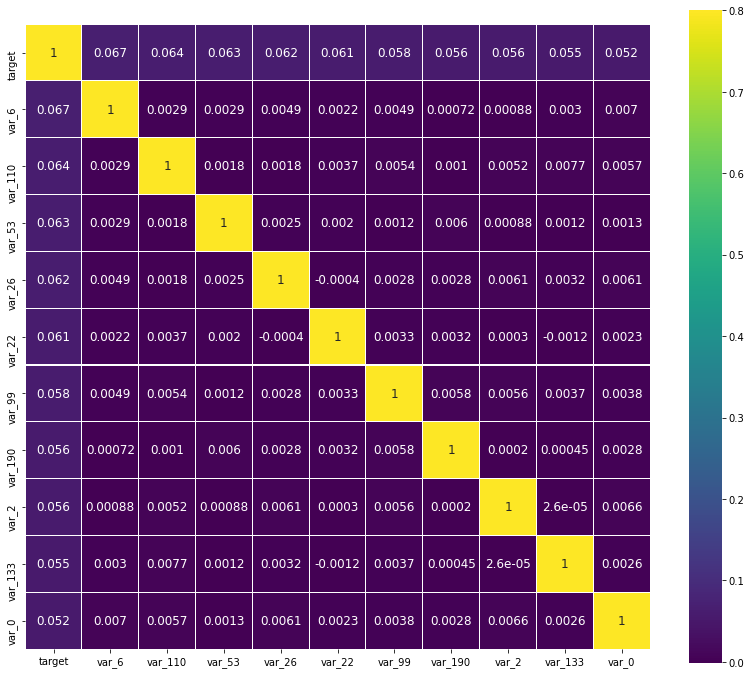

In [45]:
k = 11
cols = correlation.nlargest(k, TARGET_COLUMN)[TARGET_COLUMN].index
cm = np.corrcoef(train[cols].values.T)
fig, axes = plt.subplots(figsize = (14, 12))

sns.heatmap(
    cm,
    vmax=.8,
    linewidths=0.01,
    cmap="viridis",
    square=True,
    annot=True,
    linecolor="white",
    xticklabels=cols.values,
    annot_kws = {"size": 12},
    yticklabels=cols.values
)

### Нелинейная связь

In [47]:
%%time
parameters = {"max_depth": 6, "n_estimators": 25, "random_state": 27, "n_jobs": 2}

forest = RandomForestRegressor(**parameters)
forest.fit(numerical_features, target)

CPU times: user 13min 30s, sys: 188 ms, total: 13min 30s
Wall time: 7min 3s


Text(0.5, 1.0, 'What are the top important features to start with?')

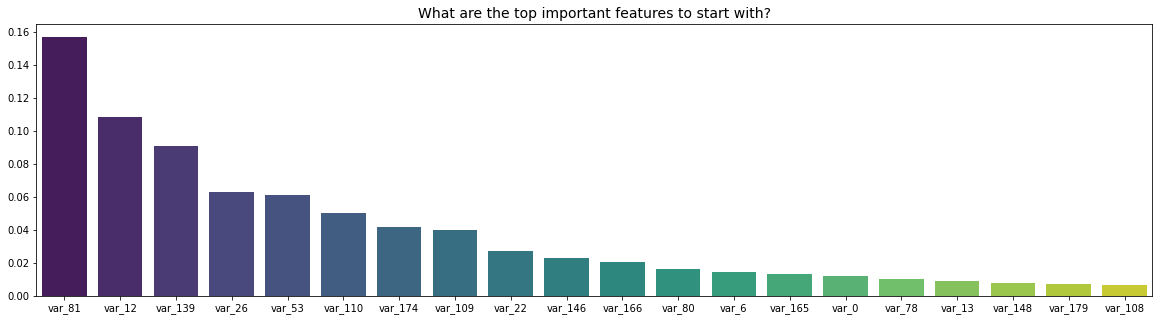

In [48]:
n_top = 20
importances = forest.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = numerical_features.columns

plt.figure(figsize=(20, 5))
sns.barplot(x=feature_names[idx], y=importances[idx], palette="viridis")
plt.title("What are the top important features to start with?", size=14)

In [59]:
top_nonlinear_features = list(feature_names[np.argsort(importances)[::-1][0:10]])

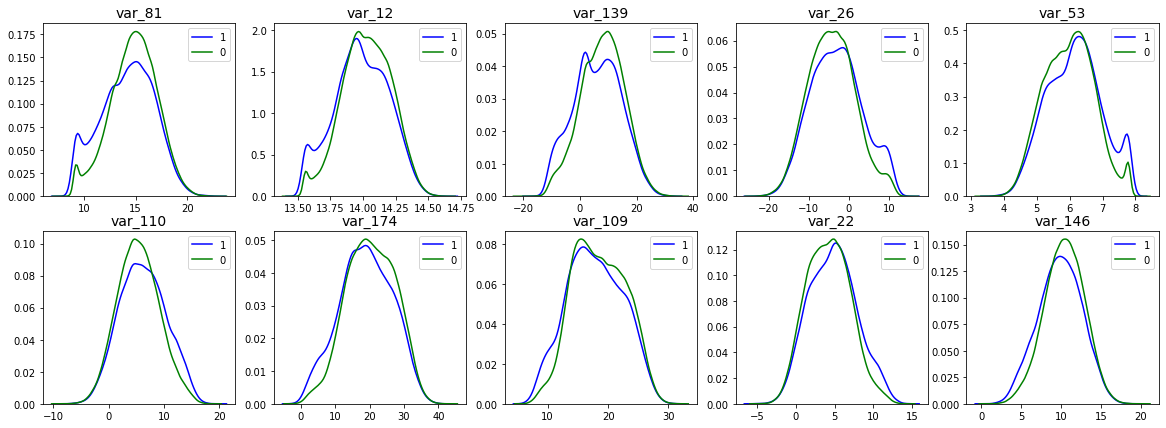

In [61]:
fig, axes = plt.subplots(2, 5, figsize=(20, 7))
axes = axes.flatten()

for num, feature in enumerate(top_nonlinear_features):
    try:
        positive_data = train.loc[train[TARGET_COLUMN] == 1, feature].copy()
        negative_data = train.loc[train[TARGET_COLUMN] == 0, feature].copy()
        sns.kdeplot(positive_data, ax=axes[num], color="blue", label="1")
        sns.kdeplot(negative_data, ax=axes[num], color="green", label="0")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num], color="blue", label="train")
    axes[num].set_title(feature, fontsize=14)

### ВЫВОД

Между признаками полностью отсутсвуют какие-либо линейные связи, признаки нескоррелированы. <br>
Однако между целевой переменной и другими признаками наблюдаются нелинейные связи, судя по всему - это топ признаков, обладающих наиболее различными распределениями на тренировочной и тестовой выборке. Топ-10 признаков, имеющих нелинейную связь с целевой переменной: 'var_81', 'var_12', 'var_139', 'var_26', 'var_53', 'var_110', 'var_174', 'var_109', 'var_22', 'var_146'